Data from - https://catalog.data.gov/dataset/employee-salaries-2023

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
salaries = pd.read_csv('Datasets/Employee_Salaries_-_2023.csv')
salaries.head()

,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Grade
0,ABS,Alcohol Beverage Services,ABS 85 Administration,M,175873.000,0.00,0.0,M2
1,ABS,Alcohol Beverage Services,ABS 85 Administration,M,145613.360,0.00,0.0,M3
2,ABS,Alcohol Beverage Services,ABS 85 Administration,F,136970.000,0.00,0.0,M3
3,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,89432.694,0.00,2490.0,21
4,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,78947.000,456.68,6257.7,16


In [4]:
for i in range(len(salaries)):
    salaries.iloc[i,2] = re.search( r"\d+\s+(.*)",salaries.iloc[i,2]).group(1)
salaries = salaries.drop(columns=['Department_Name'])
salaries.head()

,Department,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Grade
0,ABS,Administration,M,175873.000,0.00,0.0,M2
1,ABS,Administration,M,145613.360,0.00,0.0,M3
2,ABS,Administration,F,136970.000,0.00,0.0,M3
3,ABS,Administrative Services,F,89432.694,0.00,2490.0,21
4,ABS,Administrative Services,F,78947.000,456.68,6257.7,16


In [5]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10291 entries, 0 to 10290
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Department     10291 non-null  object 
 1   Division       10291 non-null  object 
 2   Gender         10291 non-null  object 
 3   Base_Salary    10291 non-null  float64
 4   Overtime_Pay   10291 non-null  float64
 5   Longevity_Pay  10291 non-null  float64
 6   Grade          10258 non-null  object 
dtypes: float64(3), object(4)
memory usage: 562.9+ KB


In [6]:
salaries = salaries[~salaries.Grade.isna()]
salaries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10258 entries, 0 to 10290
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Department     10258 non-null  object 
 1   Division       10258 non-null  object 
 2   Gender         10258 non-null  object 
 3   Base_Salary    10258 non-null  float64
 4   Overtime_Pay   10258 non-null  float64
 5   Longevity_Pay  10258 non-null  float64
 6   Grade          10258 non-null  object 
dtypes: float64(3), object(4)
memory usage: 641.1+ KB


In [7]:
salaries.describe(include='object')

,Department,Division,Gender,Grade
count,10258,10258,10258,10258
unique,42,593,2,98
top,HHS,School Health Services,M,T1
freq,1874,399,5913,687


In [8]:
salaries.describe()

,Base_Salary,Overtime_Pay,Longevity_Pay
count,10258.000000,10258.000000,10258.000000
mean,90071.368933,8107.286472,1538.731733
std,30899.163148,16511.959712,3213.046927
min,18257.500000,0.000000,0.000000
25%,70023.000000,0.000000,0.000000
50%,87287.000000,270.365000,0.000000
75%,108084.000000,9235.837500,1228.890000
max,292000.000000,227428.990000,20279.460000


# EDA

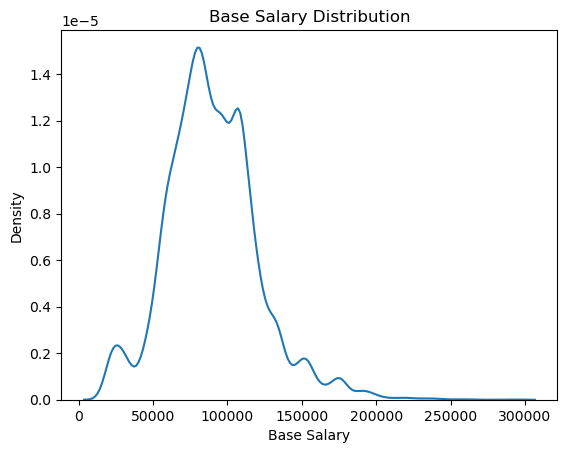

In [9]:
sns.kdeplot(salaries.Base_Salary)
plt.title('Base Salary Distribution')
plt.xlabel('Base Salary')
plt.show()

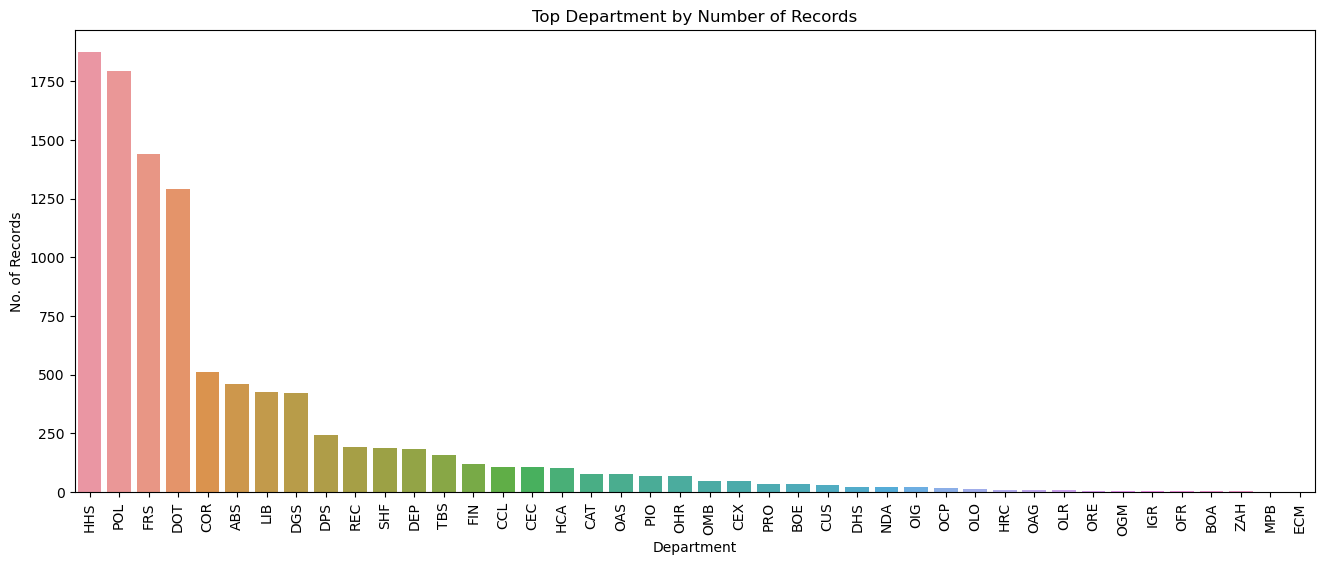

In [10]:
plt.figure(figsize=(16,6))
Department = salaries.groupby('Department')['Base_Salary'].count().sort_values(ascending=False)
sns.barplot(x=Department.index, y= Department.values)
plt.title('Top Department by Number of Records')
plt.ylabel('No. of Records')
plt.xticks(rotation=90)
plt.show()

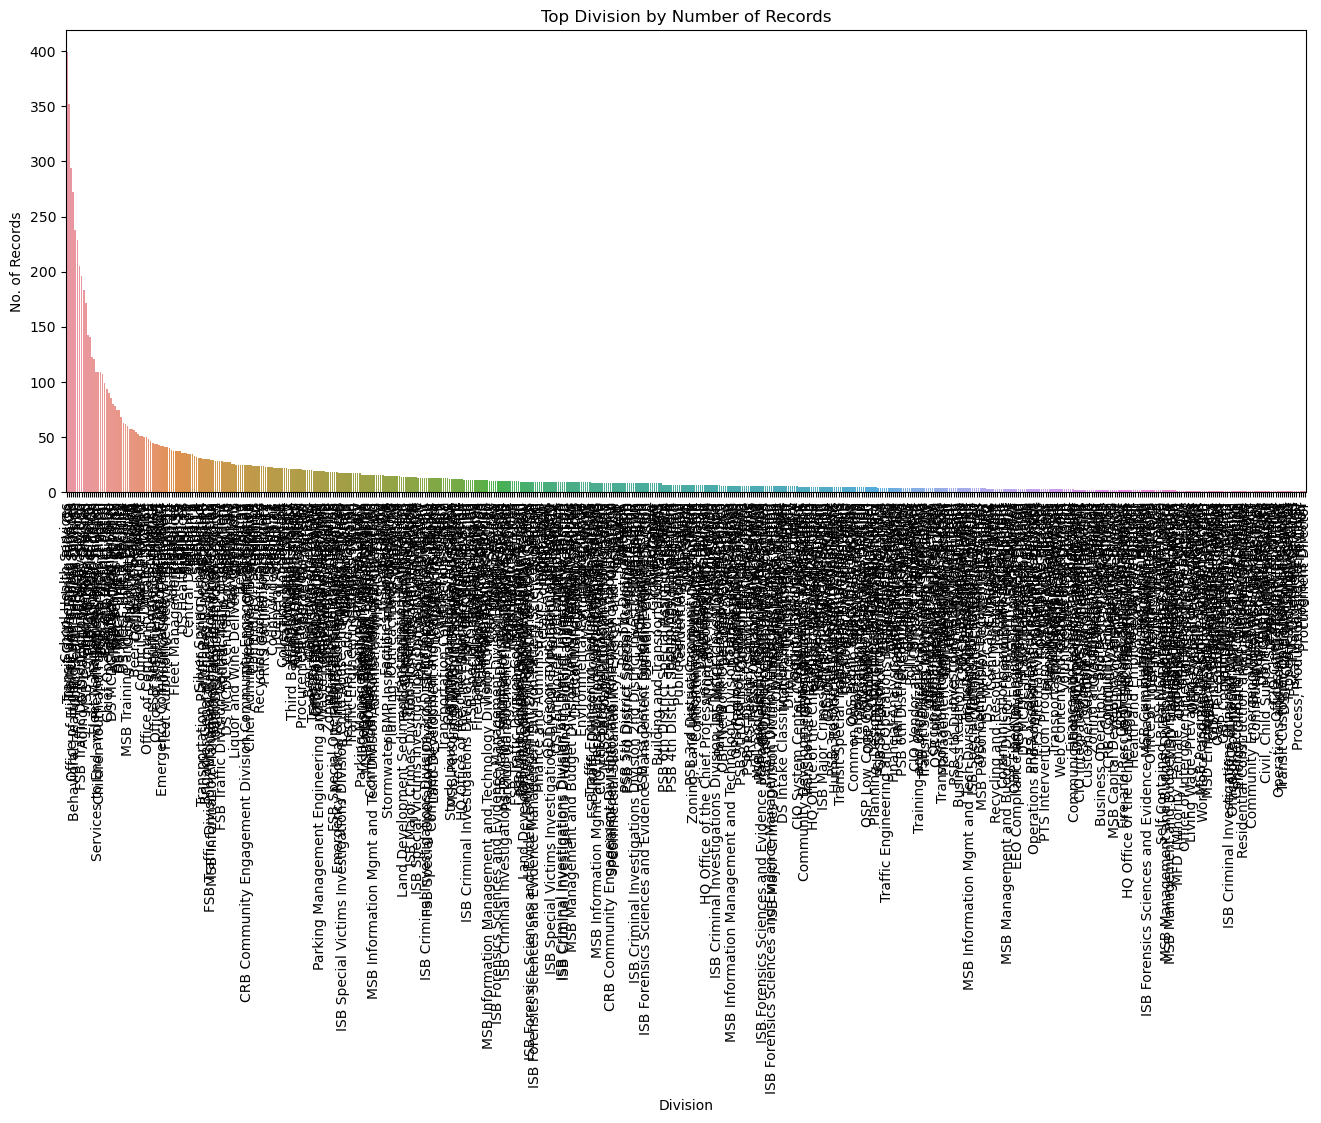

In [11]:
plt.figure(figsize=(16,6))
Division = salaries.groupby('Division')['Base_Salary'].count().sort_values(ascending=False)
sns.barplot(x=Division.index, y= Division.values)
plt.title('Top Division by Number of Records')
plt.ylabel('No. of Records')
plt.xticks(rotation=90)
plt.show()

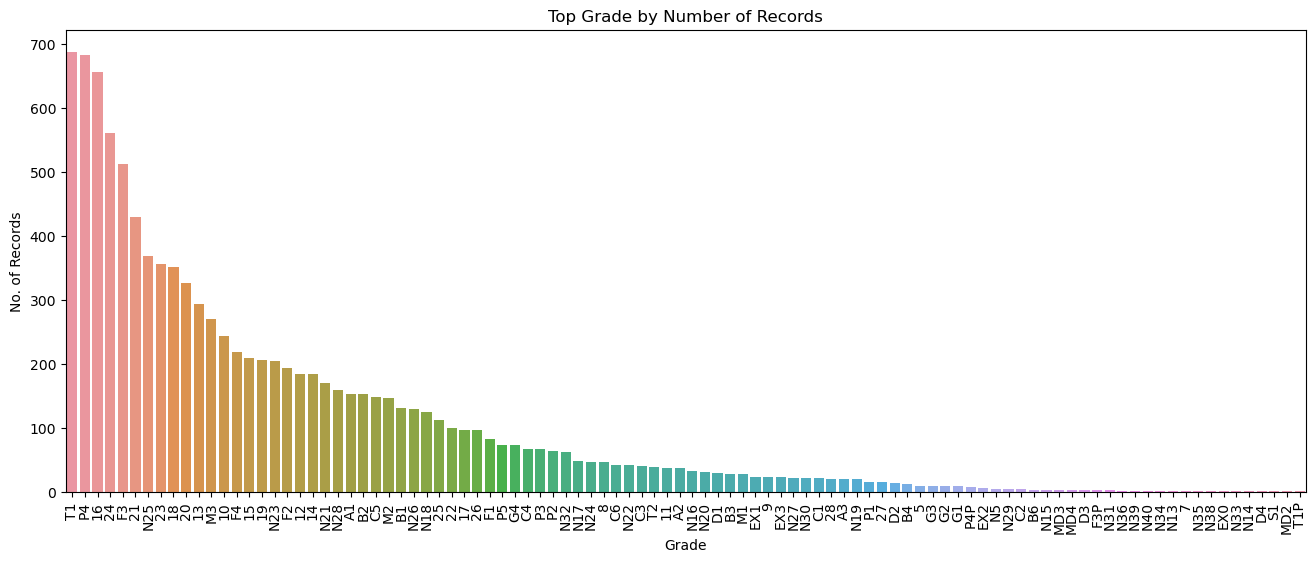

In [12]:
plt.figure(figsize=(16,6))
Grade = salaries.groupby('Grade')['Base_Salary'].count().sort_values(ascending=False)
sns.barplot(x=Grade.index, y= Grade.values)
plt.title('Top Grade by Number of Records')
plt.ylabel('No. of Records')
plt.xticks(rotation=90)
plt.show()

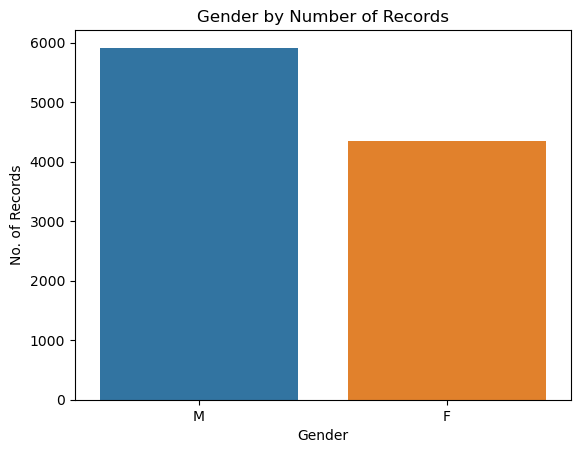

In [13]:
Gender = salaries.groupby('Gender')['Base_Salary'].count().sort_values(ascending=False)
sns.barplot(x=Gender.index, y= Gender.values)
plt.title('Gender by Number of Records')
plt.ylabel('No. of Records')
plt.show()

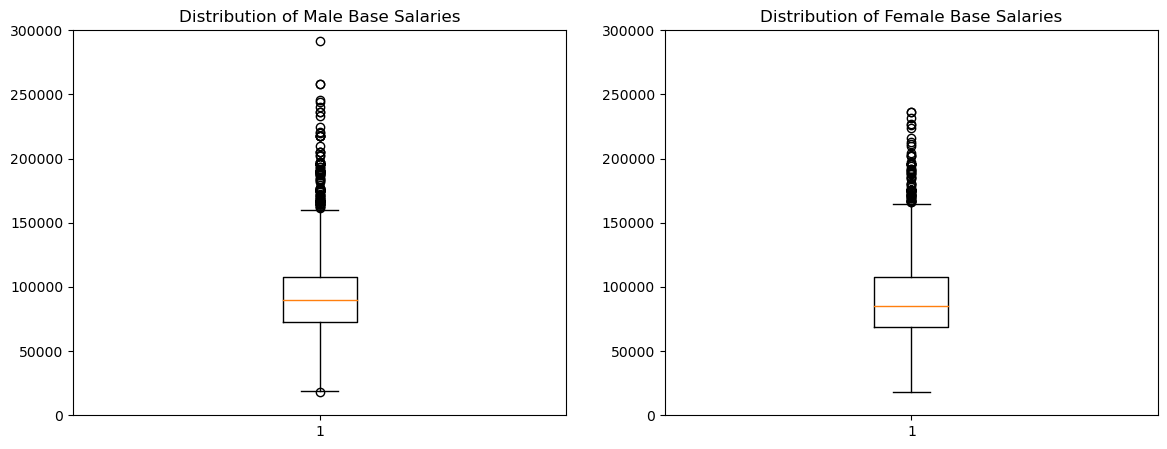

In [14]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].boxplot(salaries[salaries['Gender']=='M']['Base_Salary'])
ax[0].title.set_text('Distribution of Male Base Salaries')
ax[1].boxplot(salaries[salaries['Gender']=='F']['Base_Salary'])
ax[1].title.set_text('Distribution of Female Base Salaries')
plt.setp(ax,ylim=(0,300000))
plt.show()

## Chi-Square Tests

In [15]:
Department_crosstab = pd.crosstab(salaries['Department'], salaries['Base_Salary'])
chi2_statistic, pval, degrees_of_freedom, expected_frequency = chi2_contingency(Department_crosstab.values)

print("Chi-Square Statistic:", chi2_statistic)
print("p-value:", pval)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 266047.8259043812
p-value: 0.0
Degrees of Freedom: 141450


In [16]:
Division_crosstab = pd.crosstab(salaries['Division'], salaries['Base_Salary'])
chi2_statistic, pval, degrees_of_freedom, expected_frequency = chi2_contingency(Division_crosstab.values)

print("Chi-Square Statistic:", chi2_statistic)
print("p-value:", pval)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 2533348.6252197837
p-value: 0.0
Degrees of Freedom: 2042400


In [17]:
Grade_crosstab = pd.crosstab(salaries['Grade'], salaries['Base_Salary'])
chi2_statistic, pval, degrees_of_freedom, expected_frequency = chi2_contingency(Grade_crosstab.values)

print("Chi-Square Statistic:", chi2_statistic)
print("p-value:", pval)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 876511.7854271544
p-value: 0.0
Degrees of Freedom: 334650


<Axes: >

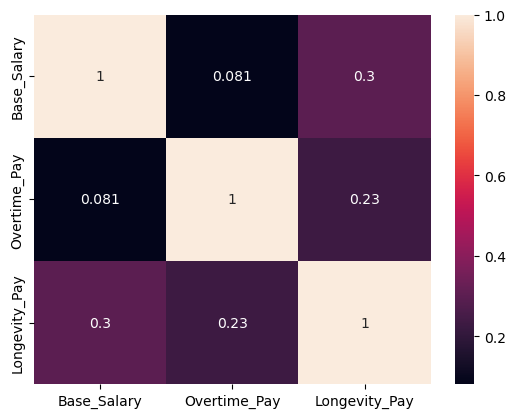

In [18]:
sns.heatmap(salaries.select_dtypes(exclude='object').corr(),annot=True)

# Feature Selection & Transformation

In [19]:
X = salaries.drop('Base_Salary', axis=1)
y = salaries['Base_Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
numeric_features = ["Overtime_Pay","Longevity_Pay"]
categorical_features = ['Department', 'Division', 'Grade', 'Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
    ]
)

In [21]:
# X_train_scaled = preprocessor.fit_transform(X_train)
# X_test_scaled = preprocessor.transform(X_test)

# Modeling

In [22]:
# for model in [RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42),XGBRegressor(random_state=42)]:
#     model_trial = model
#     t0 = time.time()
#     model_trial.fit(X_train_scaled, y_train)
#     y_pred = model_trial.predict(X_test_scaled)
#     print(f'RMSE for {type(model).__name__}: {mean_squared_error(y_test, y_pred, squared=False)} ({round(time.time()-t0,2)} seconds)')

In [23]:
# xgbr = XGBRegressor(randon_state= 42)
# param_grid = {
#     'n_estimators': randint(50, 200),
#     'max_depth': randint(3, 10),
#     'learning_rate': uniform(0.01, 0.3),
#     'subsample': uniform(0.6, 0.4),
#     'colsample_bytree': uniform(0.6, 0.4),
#     'gamma': uniform(0, 0.5),
#     'reg_alpha': uniform(0, 0.5),
#     'reg_lambda': uniform(0, 0.5)
# }
# random_search = RandomizedSearchCV(estimator=xgbr, param_distributions=param_grid,
#                                    n_iter=100, scoring='neg_mean_squared_error',
#                                    cv=5, verbose=2, random_state=42, n_jobs=-1)

# random_search.fit(X_train_scaled, y_train)

# print(random_search.best_params_)
# print(random_search.best_score_)
# 'colsample_bytree': 0.6192235696788134, 'gamma': 0.47457286579569297, 'learning_rate': 0.2760041161894143, 'max_depth': 6, 'n_estimators': 187, 'reg_alpha': 0.3129299578571182, 'reg_lambda': 0.25156812929004385, 'subsample': 0.9425959364753289

In [24]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', XGBRegressor(colsample_bytree=0.62, gamma=0.47, learning_rate=0.28, max_depth=6, n_estimators=187,
                      reg_alpha=0.31, reg_lambda=0.25, subsample=0.94))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE: 9868.631358889408


# Model Dumping

In [25]:
import pickle

model.fit(X, y)

with open('salary_predict.pkl', 'wb') as file:
    pickle.dump(model, file)